In [2]:
## Install and load packages ======================================================

!apt install libspatialindex-dev
!pip install osmnx
import numpy as np
import pandas as pd
import seaborn as sns
# !pip uninstall matplotlib
# !pip install matplotlib==3.1.3
import matplotlib.pyplot as plt
import IPython.display as disp
import osmnx as ox
import networkx as nx
from datetime import timedelta
from shapely.geometry import Polygon, LineString, Point
import itertools as iter

!pip install geneticalgorithm
from geneticalgorithm import geneticalgorithm as ga
import math
%matplotlib inline
ox.config(log_console=True)
ox.__version__


Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-dev is already the newest version (1.8.5-5).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 44 kB 2.7 MB/s 
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15098 sha256=906313fb7d352899563fa8f784be87cdff8911d6564d69742db89ba0c4048766
  Stored in directory: /root/.cache/pip/wheels/68/b5/a5/67c4364c354e141f5a1bd3ec568126f77877ab7554cf5af8cb
Successfully built func-timeout


'1.1.2'

## Define core functions

In [7]:

def site_extraction(place = "San Juan, Batangas, Philippines", 
                    tags = { "amenity": ["hospital", "school", "kindergarten", "college", "university"]}):
  
  ## Automated extraction of schools and hospitals

    tags = tags
    place = place
    # get all building footprints in some neighborhood
    df = ox.geometries_from_place(place, tags)
    df["latlong"] = df.geometry.centroid
    df.reset_index(level=0, inplace=True)
    #df =df[["name", "latlong"]]
    return df



def Lsite_optimization(vacc, vill, 
                       L = 3, graph_area = ("San Juan, Batangas, Philippines"),
                        distance = "road", return_distances = False, enumerative = False):
  
  ## @vacc =   Vaccination centers dataframe
  ## @villages =  Village centers dataframe
  ## @L =  number of vaccination sites to be used for optimization
  ## graph_area = string of the region name
  ## distance = string of the distance type, can be "road", "euclidean", or 'time
  ## return_distances = If true, the function will return the distances matrix between each village center and each vaccination site
  ## enumerative = If true, every possible combination of vaccination centers will be iterated on. 
  ##                If false, genetic algorithms will be used for speed.  
  
  TI = vill.infected.sum()
  TP = vill.population.sum() 
  vill["weight"] = vill.infected/TI + vill.population/TP

  ##  Automated N-site Optimization!!! ================================================================

  ## Select Open Street Map code for the given province 

  graph_area = graph_area

  # Create the graph of the area from OSM data. It will download the data and create the graph
  G = ox.graph_from_place(graph_area, network_type='drive')
  G = ox.add_edge_speeds(G)
  G = ox.add_edge_travel_times(G)


  ## Phase 1: N-site  Distance Matrix------------------------------------------------------------------
  index = vacc.Name
  columns = vill.Village_name
  df_distances = pd.DataFrame(index=index, columns = columns)
  
  for i in vacc.index:
    for j in vill.index:
      if distance == "road":
        #Get pure road distance
        origin_node = ox.distance.nearest_nodes(G, Y = vill.iloc[j].latitude, X = vill.iloc[j].longitude)
        destination_node = ox.distance.nearest_nodes(G, Y = vacc.iloc[i].latitude, X = vacc.iloc[i].longitude)
        
        df_distances.iloc[i,j] = nx.shortest_path_length(G, 
                                            origin_node, destination_node, weight='length')
      if distance == "euclidean":
        df_distances.iloc[i,j] = ox.distance.euclidean_dist_vec(
          vacc.iloc[i].latitude, vacc.iloc[i].longitude, vill.iloc[j].latitude, vacc.iloc[j].longitude)

      if distance == "time":
        #Get pure road distance
        origin_node = ox.distance.nearest_nodes(G, Y = vill.iloc[j].latitude, X = vill.iloc[j].longitude)
        destination_node = ox.distance.nearest_nodes(G, Y = vacc.iloc[i].latitude, X = vacc.iloc[i].longitude)
        
        df_distances.iloc[i,j] = nx.shortest_path_length(G, 
                                            origin_node, destination_node, weight='travel_time')


  index1 = list(iter.combinations(df_distances.index, L))
  master = pd.DataFrame(index=index1, columns = vill.Village_name)

  print("phase 1 complete,  distance matrix computed")

  #Phase 2 ---------------------------------------------------------------------------

  if enumerative is True:
    for i, name in enumerate(list(iter.combinations(df_distances.index, L))):
        #print(i)
        for j in vill.index:
          # Get weights
          weight = vill["weight"][j]
          sads = [None]*L
          for k in np.arange(0,L):
            sads[k] = df_distances.loc[name[k]][j]
          master.iloc[i,j] = weight*min(sads)
    print("phase 2 complete, optimization finished")

    ## Display Best Vaccination centers! 
    results_Lsite = pd.DataFrame(master.sum(axis=1))
    results_Lsite.columns = ["Cost"]
    if return_distances is True:
      return results_Lsite.sort_values(by=['Cost'], ascending=True), df_distances
    else:
      return results_Lsite.sort_values(by=['Cost'], ascending=True) 


  else:

    ## Combinatorial Genetic Algorithm Optimization 
    varbound=np.array([[0,vacc.shape[0]-1]]*L)
    
    master = pd.DataFrame(0, index=[0], columns=vill.Village_name)
    def f(x):
      x = x.tolist()
      for j in vill.index:
        # Get weights
        weight = vill["weight"][j]
        sads = [None]*L
        for k in np.arange(0,L):     
          sads[k] = df_distances.iloc[math.ceil(x[k]),j]
        master.iloc[0,j] = weight*min(sads)
      fitness = master.sum(axis=1)[0]
      return fitness
    

    algorithm_param = {'max_num_iteration': 300*L,
                      'population_size': 20*(L**2),
                      'mutation_probability':0.1,
                      'elit_ratio': 0.01,
                      'crossover_probability': 0.5,
                      'parents_portion': 0.3,
                      'crossover_type':'uniform',
                      'max_iteration_without_improv': 50}

    
    model = ga(function= f, dimension= L, variable_type='int', variable_boundaries=varbound, 
            algorithm_parameters=algorithm_param)

    print(model.run())
    

    ## Display Best Vaccination centers! 
    results_Lsite =  [int(i) for i in model.output_dict['variable'].tolist()]
    results_Lsite = tuple(df_distances.index[results_Lsite].tolist())
    wew = {'Cost': model.output_dict['function']}
    results_Lsite = pd.DataFrame(wew, index = [results_Lsite])
    
    if return_distances is True:
      return results_Lsite, df_distances
    else:
      return results_Lsite

def site_distribution(results, df_distances):

  ## results = results from the nsite_optimization function
  ## df_distances = distance matrix from the nsite_optimization function
    solution = df_distances.loc[[a for a in results.index[0]]]
    index = df_distances.columns
    columns = ["vaccination_center", "distance"]
    assignment  = pd.DataFrame(index=index, columns = columns)
    for i, name in enumerate(df_distances.columns):
      assignment.loc[name, "vaccination_center"] = solution.loc[:, [name]].sort_values(by=[name], ascending= True).index[0]
      assignment.loc[name, "distance"] = solution.loc[:, [name]].sort_values(by=[name], ascending=True).iloc[0, 0]
    
    distribution = assignment["vaccination_center"].value_counts()
    return assignment, distribution


def optimal_sites(vaccination_centers_df, villages_df,
                       L = 3,  graph_area = ("San Juan, Batangas, Philippines"), return_ranking = False, enumerative = False,
                        distance = "road", return_distances = False, plot = True):
  ## PARAMS: 
  ## @vaccinatiOn_centers_df =   Vaccination centers dataframe
  ## @villages_df =  Village centers dataframe
  ## @L =  number of vaccination sites to be used for optimization
  ## graph_area = string of the region name
  ## distance = string of the distance type, can be "road", "euclidean", or 'time
  ## return_distances = If true, the function will return the distances matrix between each village center and each vaccination site
  ## enumerative = If true, every possible combination of vaccination centers will be iterated on. 
  ##                If false, genetic algorithms will be used for speed.  
  ##return_ranking = If true, then the results from the enumeration will be the output. This can only be done when enumerative = True.
  ## plot = If true then geospatial plot is shown
  

  vacc = vaccination_centers_df
  vill = villages_df
  TI = vill.infected.sum()
  TP = vill.population.sum() 
  vill["weight"] = vill.infected/TI + vill.population/TP
  
  result_nsites, df_distances = Lsite_optimization(vacc = vacc, vill = vill, L = L, graph_area = graph_area,
                                                   distance = distance, return_distances = True, enumerative = enumerative)
  assignment_nsite, distribution_nsite = site_distribution(results =  result_nsites, df_distances = df_distances)


  ## Plotting!!! =================================================================================================

  #Create the graph of the area from OSM data. 
  G = ox.graph_from_place(graph_area, network_type='drive')
  G = ox.add_edge_speeds(G)
  G = ox.add_edge_travel_times(G)

  ## Get coordinates of optimal sites
  optimal_sites = list(assignment_nsite.vaccination_center.unique())
  optimal_sites_loc = vacc[vacc.Name.isin(optimal_sites)] 
  optimal_sites_loc["colors"] = optimal_sites_loc["Name"].astype('category').cat.codes
  optimal_sites_loc

  # Get coordinates and assignments of barangays 
  wew = pd.merge(assignment_nsite, vill, on = "Village_name")
  wew["colors"] = wew["vaccination_center"].astype('category').cat.codes
  wew = wew.rename(columns={'vaccination_center': 'assigned_vaccination_center'})

  if plot is True:
      plt.figure(figsize=(25, 17), dpi=1500)
      fig, ax = ox.plot_graph(G, edge_color = None, show=False, close=False, bgcolor = "white",
                              edge_linewidth=1, node_size=1, figsize=(25, 20), dpi = 20000)

      ax.scatter(wew.longitude, wew.latitude, s= 100, c=wew["colors"], linewidths=1, edgecolors = "black", cmap='viridis')
      ax.scatter(optimal_sites_loc.longitude, optimal_sites_loc.latitude, s = 800, edgecolors = "black",
                c=optimal_sites_loc["colors"], linewidths=2, marker = "*")
      plt.show()
      

  if return_distances is True:
    if return_ranking is True:
      return assignment_nsite, df_distances, result_nsites
    else:
      return assignment_nsite, df_distances
  else:
    if return_ranking is True:
     return assignment_nsite, result_nsites
    else:
      return assignment_nsite

##Sample Usage

In [ ]:
## Alternative automated way to obtain a partial vaccinations table =============
site_extraction(place = "Los Banos, Laguna")

/usr/local/lib/python3.7/dist-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/usr/local/lib/python3.7/dist-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # This is added back by InteractiveShellApp.init_path()


,element_type,geometry,barrier,alt_name,amenity,name,emergency,name:en,nodes,addr:city,...,name:etymology,name:etymology:wikidata,old_name:en,old_name:tl,abbr_name,addr:barangay,addr:country,ways,type,latlong
osmid,,,,,,,,,,,,,,,,,,,,,
769875575,node,POINT (121.24330 14.16433),NaN,CDL,kindergarten,Child Development Laboratory,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.24330 14.16433)
4761472623,node,POINT (121.25149 14.18101),NaN,NaN,school,Saint Anthony School,NaN,Saint Anthony School,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.25149 14.18101)
35602697,way,"POLYGON ((121.23069 14.18777, 121.23128 14.188...",NaN,NaN,university,Laguna State Polytechnic University-Los Baños ...,NaN,NaN,"[34331502, 1252148947, 8585151014, 1252148244,...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.23127 14.18724)
37331969,way,"POLYGON ((121.23921 14.16357, 121.23938 14.163...",NaN,NaN,school,UPLB Graduate School,NaN,NaN,"[435136476, 1252052186, 2179918609, 1252052075...",Los Baños,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.23931 14.16370)
37901285,way,"POLYGON ((121.24563 14.17245, 121.24604 14.172...",NaN,NaN,school,Franciscan Montessori School of the Nativity,NaN,NaN,"[444820076, 2475309847, 2475309849, 444820077,...",Los Baños,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.24603 14.17283)
38418450,way,"POLYGON ((121.24196 14.17144, 121.24168 14.171...",NaN,NaN,school,Los Baños National High School – Batong Malaki,NaN,Los Baños National High School – Batong Malaki,"[829759546, 829759541, 454117026, 454117027, 4...",Los Baños,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.24166 14.17101)
42487765,way,"POLYGON ((121.24267 14.16480, 121.24287 14.164...",NaN,NaN,school,Maquiling School,NaN,NaN,"[530612305, 1660378834, 530612307, 1252052077,...",Los Baños,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.24326 14.16543)
53057234,way,"POLYGON ((121.24304 14.17102, 121.24309 14.171...",NaN,NaN,hospital,Los Baños Doctors Hospital and Medical Center,NaN,NaN,"[670397927, 1513696420, 1513696412, 671865462,...",Los Baños,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.24322 14.17080)
57687660,way,"POLYGON ((121.23922 14.17635, 121.23938 14.176...",wall,NaN,college,Trace College,NaN,NaN,"[920087432, 920087433, 920087434, 1143775763, ...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.23919 14.17670)


phase 1 complete,  distance matrix computed
phase 2 complete, optimization finished


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<Figure size 37500x25500 with 0 Axes>

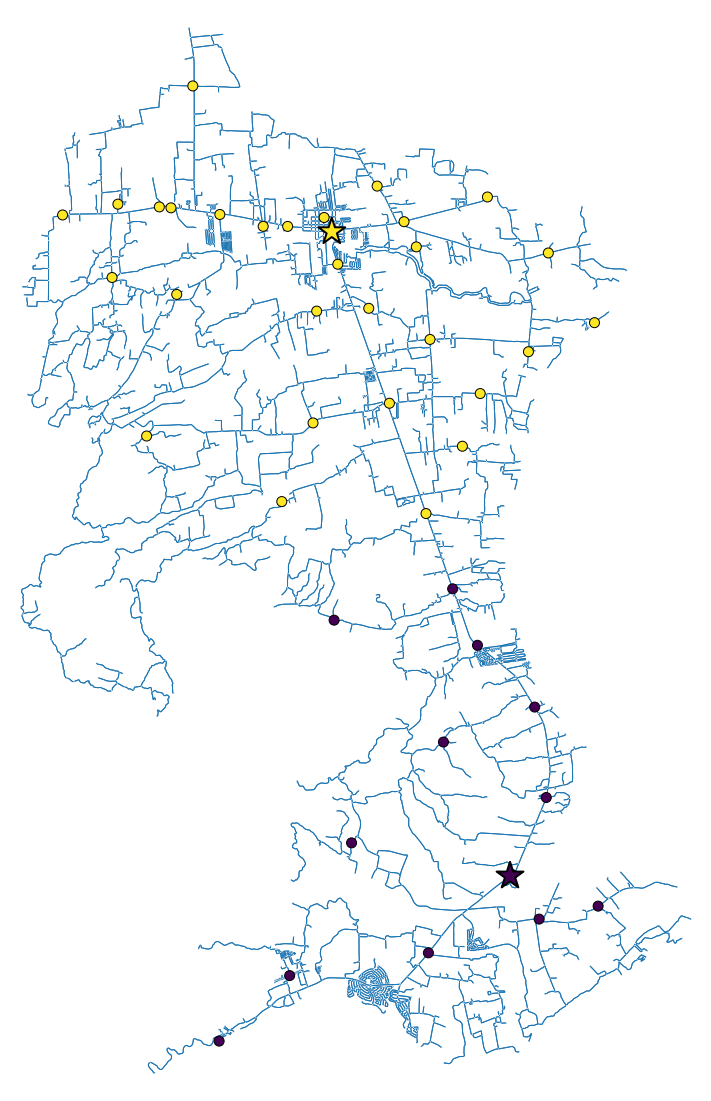

,vaccination_center,distance
Village_name,,
Abung,San Juan Rural Health Unit I,6692.135
Balagbag,San Juan Rural Health Unit I,4064.302
Barualte,Paaralang Elementarya ng Bataan,2693.793
Bataan,Paaralang Elementarya ng Bataan,0
Buhay Na Sapa,San Juan Rural Health Unit I,4115.14
Bulsa,Paaralang Elementarya ng Bataan,4552.727
Calicanto,San Juan Rural Health Unit I,1857.736
Calitcalit,San Juan Rural Health Unit I,1684.927
Calubcub I,Paaralang Elementarya ng Bataan,7485.99


In [8]:
## Load Data
vacc = pd.read_excel('Vaccination_Centers_Table.xlsx')
vill = pd.read_excel('Village_Centers_Table.xlsx')

#Set how many vaccination sites
L = 2

## Run enumerative algorithm and return village assignments, distance matrix, and ranking of all other suboptimal site combinations
assignment2, df_distances, results2 = optimal_sites(L = 2, vaccination_centers_df = vacc, villages_df = vill,
                        graph_area = ("San Juan, Batangas, Philippines"), return_ranking = True, enumerative = True,
                        distance = "road", return_distances = True, plot = True)

assignment2

In [10]:
## Check other suboptimal combinations of L sites ==========================
results2

,Cost
"(San Juan Rural Health Unit I, Paaralang Elementarya ng Bataan)",7810.470480
"(San Juan Rural Health Unit I, Nagsaulay Elementary School)",7876.825334
"(San Juan Rural Health Unit I, Laiya Elementary School)",7880.320134
"(San Juan Rural Health Unit I, Laiya National High School)",7880.320134
"(San Juan Rural Health Unit I, Nagsaulay NHS)",7941.340861
...,...
"(Hugom Elementary School, Aplaya Elementary School)",35280.298253
"(Aplaya Elementary School, Wenceslao I. Llana Memorial School)",35369.369995
"(Hugom Elementary School, Aplaya National High School)",38222.644960
"(Wenceslao I. Llana Memorial School, Aplaya National High School)",38290.500602


phase 1 complete,  distance matrix computed
 The best solution found:
 [ 0. 23.  1. 58.]

 Objective function:
 4997.075549635727


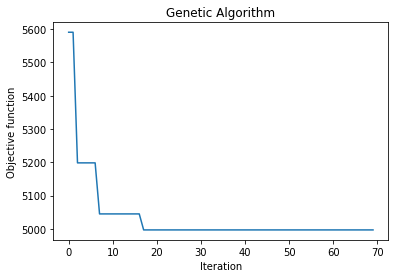

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<Figure size 37500x25500 with 0 Axes>

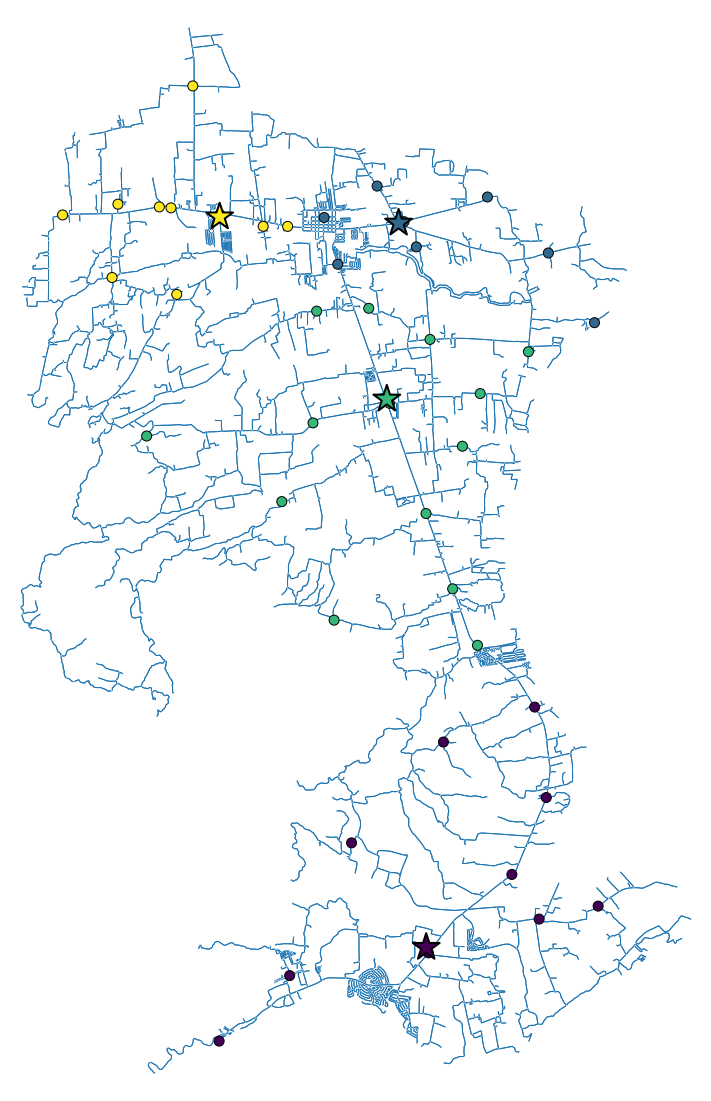

,vaccination_center,distance
Village_name,,
Abung,San Juan Rural Health Unit II,2576.995
Balagbag,San Juan Rural Health Unit II,2314.882
Barualte,Laiya Elementary School,2878.228
Bataan,Laiya Elementary School,2182.725
Buhay Na Sapa,San Juan Rural Health Unit II,0
Bulsa,Laiya Elementary School,4737.162
Calicanto,Sico 1.0 National High School,1176.853
Calitcalit,"San Juan Doctors Hospital, Inc.",143.837
Calubcub I,San Juan Rural Health Unit II,4375.893


In [11]:
## Load Data
vacc = pd.read_excel('Vaccination_Centers_Table.xlsx')
vill = pd.read_excel('Village_Centers_Table.xlsx')

#Set how many vaccination sites
L = 4

## Run genetic algorithm and return village assignments for higher L 

assignment4 = optimal_sites(L = L, vaccination_centers_df = vacc, villages_df = vill,
                        graph_area = ("San Juan, Batangas, Philippines"))

assignment4